<a href="https://colab.research.google.com/github/zualexander/mai-aiapp-computer-vision/blob/main/mai_computer_vision_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

In [2]:
import tarfile
import os
import splitfolders
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#Functions

In [27]:
def plot_accuracy_and_loss(history):

  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Download Dataset
from [howto](https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e)

In [3]:
!wget --no-check-certificate \
    ""http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"" \
    -O "/tmp/dataset.tar.gz"

--2022-05-22 18:18:11--  http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz
Resolving aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)... 132.230.105.132
Connecting to aisdatasets.informatik.uni-freiburg.de (aisdatasets.informatik.uni-freiburg.de)|132.230.105.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 541562880 (516M) [application/x-gzip]
Saving to: ‘/tmp/dataset.tar.gz’

/tmp/dataset.tar.gz 100%[===================>] 516.47M  20.5MB/s    in 26s     

2022-05-22 18:18:37 (19.7 MB/s) - ‘/tmp/dataset.tar.gz’ saved [541562880/541562880]



In [4]:
!mkdir /tmp/dataset 
!tar xf /tmp/dataset.tar.gz --directory=/tmp/dataset

# Datasplit

In [5]:
splitfolders.ratio("/tmp/dataset/images", output="/tmp/dataset/output",
    seed=1337, ratio=(.75, .25), group_prefix=None, move=False)

Copying files: 4947 files [00:02, 2391.23 files/s]


In [6]:
ls /tmp/dataset/output/train

BEANS/   CHIPS/      FISH/   JUICE/  PASTA/   SUGAR/         WATER/
CAKE/    CHOCOLATE/  FLOUR/  MILK/   RICE/    TEA/
CANDY/   COFFEE/     HONEY/  NUTS/   SODA/    TOMATO_SAUCE/
CEREAL/  CORN/       JAM/    OIL/    SPICES/  VINEGAR/


In [7]:
train = keras.utils.image_dataset_from_directory(
    directory='/tmp/dataset/output/train/',
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=32,
    image_size=(256, 256))

validation = keras.utils.image_dataset_from_directory(
    directory='/tmp/dataset/output/val/',
    labels='inferred',
    label_mode='categorical',
    crop_to_aspect_ratio=True,
    batch_size=32,
    image_size=(256, 256))


Found 3699 files belonging to 25 classes.
Found 1248 files belonging to 25 classes.


In [8]:
print(len(train.class_names))

25


# Model

In [9]:
resnet_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=len(train.class_names)
) 

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
model = keras.models.Sequential()

for layer in resnet_model.layers:
        layer.trainable=False

model.add(resnet_model)

In [11]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(len(train.class_names), activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 512)               67109376  
                                                                 
 dense_1 (Dense)             (None, 25)                12825     
                                                                 
Total params: 90,709,913
Trainable params: 67,122,201
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
#compile model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

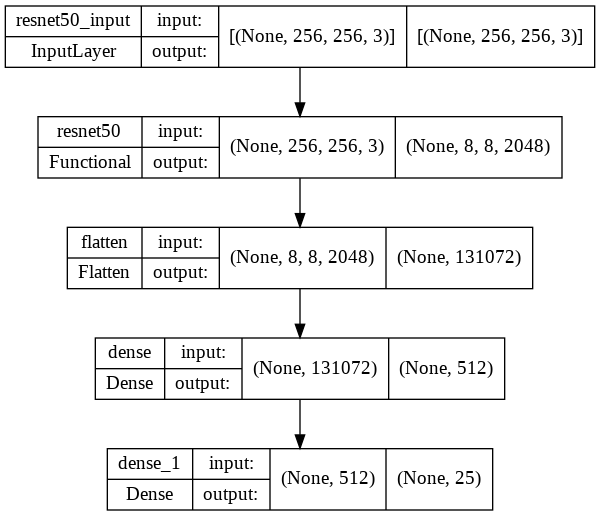

In [15]:
keras.utils.plot_model(model,show_shapes=True)

In [16]:
hist = model.fit(train, epochs=20)

Epoch 1/20
116/116 [==============================] - 31s 142ms/step - loss: 12.3015 - acc: 0.2968
Epoch 2/20
116/116 [==============================] - 17s 137ms/step - loss: 1.1579 - acc: 0.6775
Epoch 3/20
116/116 [==============================] - 17s 138ms/step - loss: 0.4665 - acc: 0.8629
Epoch 4/20
116/116 [==============================] - 17s 138ms/step - loss: 0.1939 - acc: 0.9408
Epoch 5/20
116/116 [==============================] - 17s 139ms/step - loss: 0.0957 - acc: 0.9676
Epoch 6/20
116/116 [==============================] - 17s 139ms/step - loss: 0.0520 - acc: 0.9851
Epoch 7/20
116/116 [==============================] - 17s 140ms/step - loss: 0.0285 - acc: 0.9927
Epoch 8/20
116/116 [==============================] - 17s 143ms/step - loss: 0.0083 - acc: 0.9984
Epoch 9/20
116/116 [==============================] - 17s 143ms/step - loss: 0.0029 - acc: 0.9992
Epoch 10/20
116/116 [==============================] - 17s 143ms/step - loss: 0.0014 - acc: 0.9997
Epoch 11/20
116/11

#Model evaluation

## validation scoring

In [17]:
#evaluate on unseen data
score = model.evaluate(validation, verbose=0)

Test accuarcy: 65.79%


In [22]:
print('Test accuracy:', score[1])

Test accuracy: 0.6578525900840759


In [21]:
print('Test loss:', score[0])

Test loss: 2.083951711654663


##trainigs history

dict_keys(['loss', 'acc'])


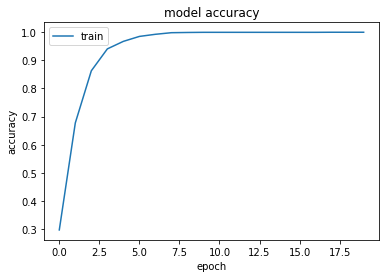

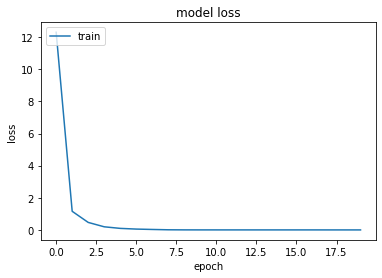

In [28]:
print(hist.history.keys())
plot_accuracy_and_loss(hist)